In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import matplotlib.pyplot as plt

In [2]:
mi.set_variant("llvm_ad_mono_polarized")

In [3]:
import sionna.rt as rt

In [4]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

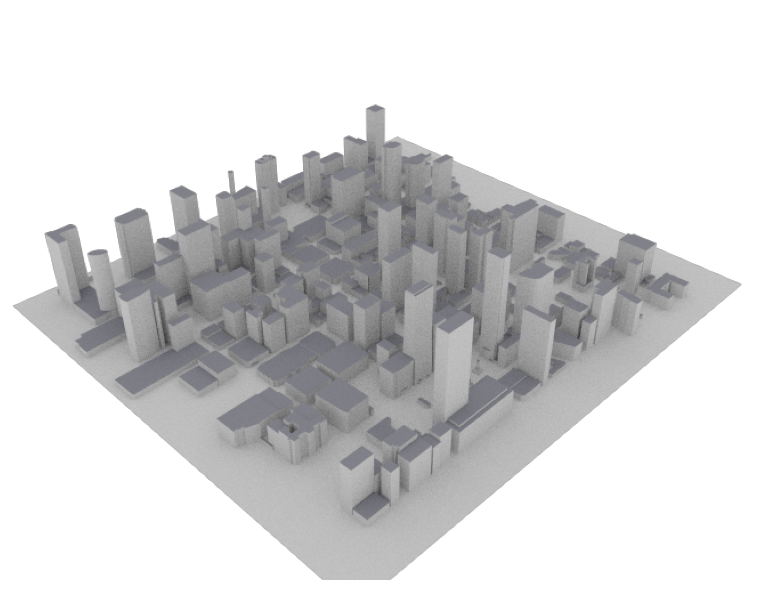

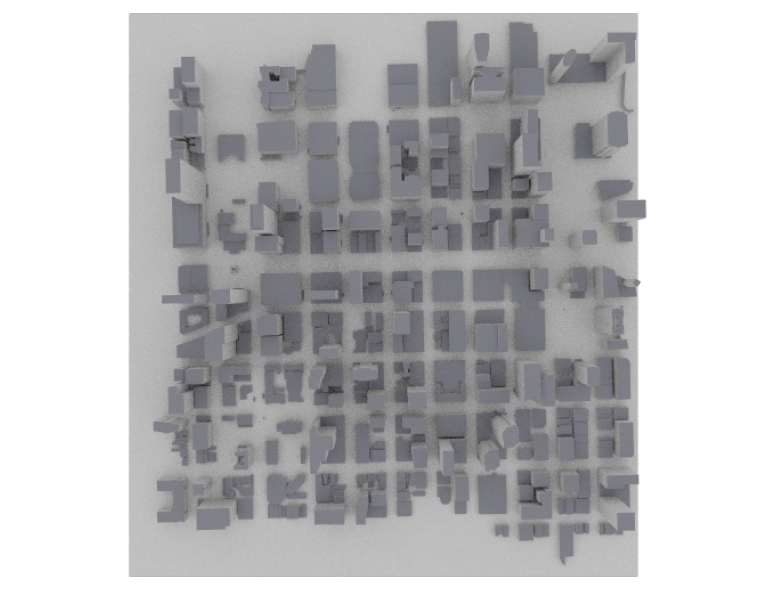

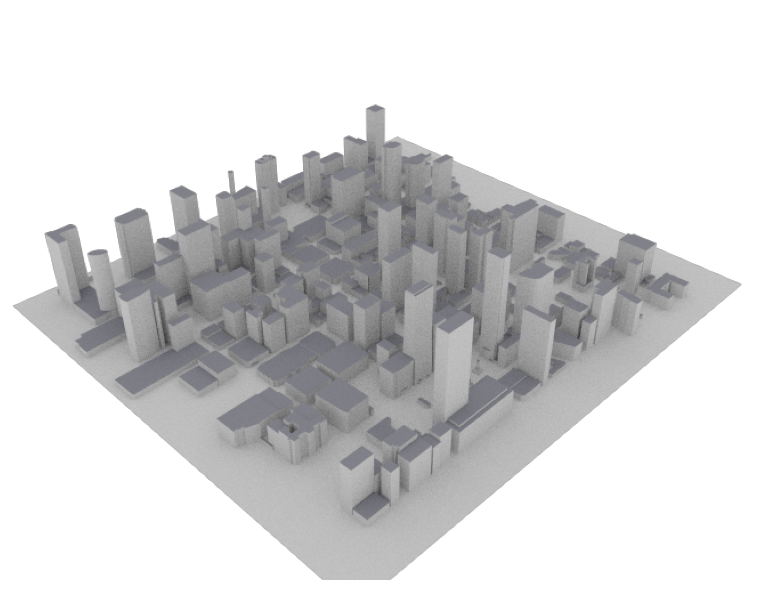

In [5]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

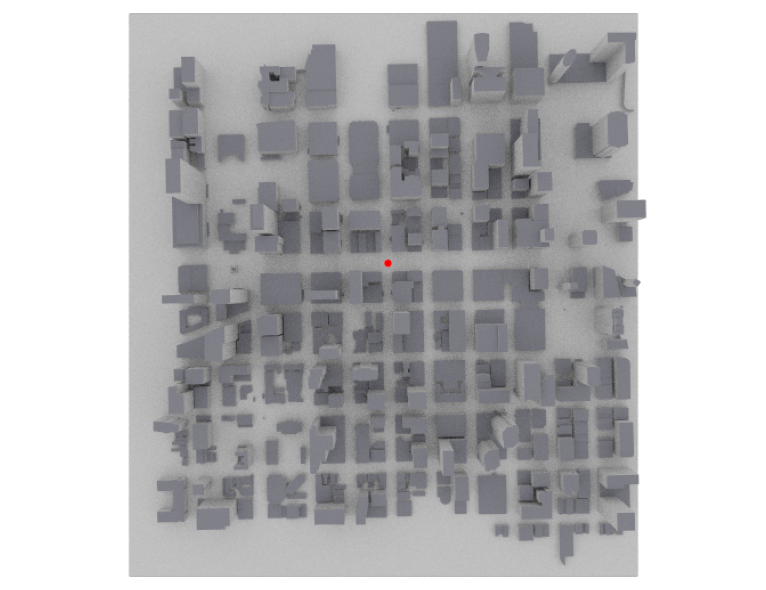

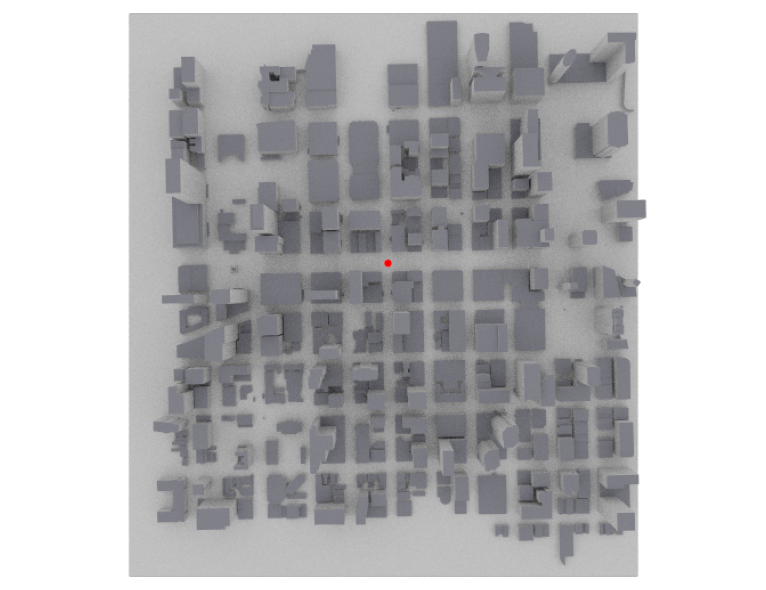

In [6]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)
# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

[[[-43.88212  -47.220066 -39.19248  ... -27.527279 -36.89488  -30.332773]
  [-38.82456  -36.872284 -38.526985 ... -32.70408  -36.558617 -46.69965 ]
  [-37.746056 -44.30783  -36.084797 ... -32.083664 -36.534008 -38.118942]
  ...
  [-52.004677 -40.193497 -38.873962 ... -51.09356  -46.365997 -40.691586]
  [      -inf -40.29384  -40.677895 ...       -inf -51.983875       -inf]
  [-60.690002 -49.757088 -49.130177 ... -40.603573       -inf       -inf]]]


C:\Users\sawyer\AppData\Local\Temp\ipykernel_24728\4087209504.py:43: RuntimeWarning: divide by zero encountered in log
  print(f"{np.log(rss)}")


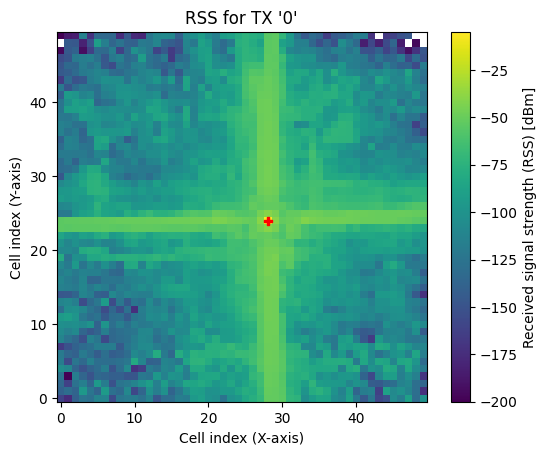

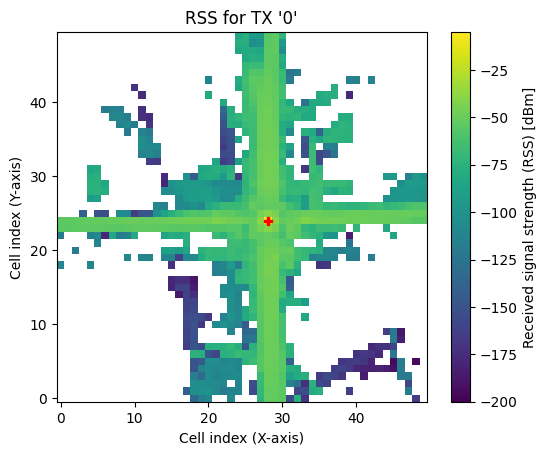

In [7]:

x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

rm = rm_solver(
    scene,
    max_depth=25,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)


rm_3 = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-200)
rm_3.show(metric="rss", tx=0, show_tx=True, vmin=-200)

rss = np.array(rm.rss)
print(f"{np.log(rss)}")


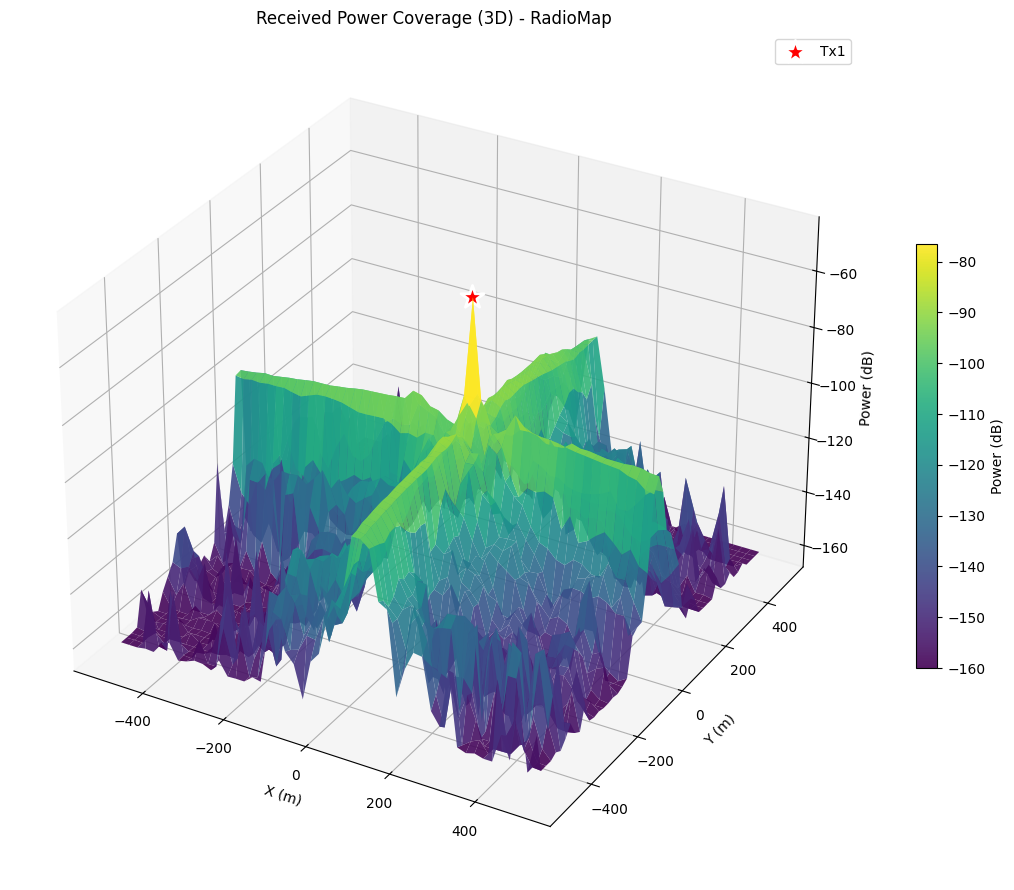


Power range: -160.00 to -49.07 dB


In [9]:
#--------------------------Visualize RadioMap Data in 3D----------------------------#
            

# Extract RadioMap data
path_gain = np.array(rm.path_gain)  # Shape: [num_tx, cells_y, cells_x]
rss_data = path_gain[0, :, :]  # Get first transmitter

# Convert to dB
power_grid_db = 10 * np.log10(rss_data + 1e-16)

# Create coordinate grids
num_cells_y, num_cells_x = power_grid_db.shape
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)
X, Y = np.meshgrid(x_coords, y_coords)

# Create 3D surface plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, power_grid_db, cmap='viridis', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Power (dB)')
ax.set_title('Received Power Coverage (3D) - RadioMap')

# Add transmitter location (at position [70, -10, 10])
tx_pos = [70, -10]
ax.scatter([tx_pos[0]], [tx_pos[1]], [power_grid_db.max()], 
           color='red', s=300, marker='*', label='Tx1', 
           edgecolors='white', linewidths=2)

fig.colorbar(surf, ax=ax, shrink=0.5, label='Power (dB)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPower range: {power_grid_db.min():.2f} to {power_grid_db.max():.2f} dB")

In [10]:
scene.preview(radio_map=rm, rm_vmin=-160)